In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Generating Functions

In [2]:
@dataclass
class Charge:
    position: tuple[float, float]
    q: float  # the charge value


def generate_multipole_charges(order: int, skew: bool = False) -> list[Charge]:
    """
    Create a multipole with 2^order charges of alternating sign, equally spaced on the unit circle.
    The normal / skew convention is defined so as to represent the one use in magnetic multipoles in
    particle accelerators. See https://en.wikipedia.org/wiki/Quadrupole_magnet for instance.

    Args:
        order (int): the order of the multipole. Has to be int or will be cast to int.
        skew (bool): if True, the multipole will be a skew one. Defaults to False.

    Returns:
        A list of Charge objects.
    """
    n_charges = 2 ** int(order)
    normal_offset = np.pi / (2 * int(order))
    skew_offset = np.pi / (2 * int(order)) if skew else 0  # non-zero only if actually skew element
    total_offset = normal_offset + skew_offset
    charges = []

    for i in range(n_charges):
        q = -1 * (i % 2 * 2 - 1)  # to alternate the signs
        x = np.cos(total_offset + 2 * np.pi * i / n_charges)
        y = np.sin(total_offset + 2 * np.pi * i / n_charges)
        charges.append(Charge(position=(x, y), q=q))
    return charges


def plot_multipole_charges(axes: plt.Axes, charges: list[Charge]) -> None:
    """Plots the charges of a multipole, from the dict returned by `generate_multipole_charges`,
    on the provided axis. Also adds a letter for the pole (N or S)."""
    charge_colors = {True: "#aa0000", False: "#0000aa"}  # red for positive, blue for negative
    charge_letter = {True: "S", False: "N"}  # South for positive, North for negative
    for charge in charges:
        axis.add_artist(Circle(charge.position, 0.06, color=charge_colors[charge.q > 0], zorder=2))
        axis.text(*charge.position, s=charge_letter[charge.q > 0], color="white", size=15, va="center", ha="center", zorder=3)

In [3]:
def E(q: float, r0: tuple[float, float], x: np.ndarray, y: np.ndarray) -> tuple[float, float]:
    """
    Return the electric field vector E = (Ex, Ey) due to a charge q at position r0.

    Args:
        q (float): the charge value.
        r0 (tuple[float, float]): position of the charge.
        x (np.ndarray): x positions at which to calculate the field.
        y (np.ndarray): y positions at which to calculate the field.

    Returns:
        The field vector (Ex, Ey) as a tuple.
    """
    denominator = np.hypot(x - r0[0], y - r0[1]) ** 3
    return q * (x - r0[0]) / denominator, q * (y - r0[1]) / denominator


def B(q: float, r0: tuple[float, float], x: np.ndarray, y: np.ndarray) -> tuple[float, float]:
    """
    Return the magnetic field vector B = (Bx, By) due to a current I at position r0.
    This uses the formula for the magnetic field due to a current-carrying wire, as
    the magnetic field due to a point charge is zero. It is assumes that by "charge"
    we would mean a pole of the magnetic multipole, with a passing current inside.

    Args:
        q (float): the charge current value.
        r0 (tuple[float, float]): position of the current charge.
        x (np.ndarray): x positions at which to calculate the field.
        y (np.ndarray): y positions at which to calculate the field.

    Returns:
        The field vector (Bx, By) as a tuple.
    """
    mu_0 = 4 * np.pi * 1e-7  # magnetic constant
    denominator = np.hypot(x - r0[0], y - r0[1]) ** 2
    Bx = mu_0 * q * (x - r0[0]) / denominator
    By = mu_0 * q * (y - r0[1]) / denominator
    return Bx, By

In [4]:
def calculate_efield_map(n_x: int, n_y: int, charges: list[Charge]) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the electric field vector values for all points in the grid of points.

    Args:
        n_x (int): number of points on the x axis.
        n_y (int): number of points on the y axis.
        charges (list[Charge]): list of charges generating the field, as returned by 'generate_multipole_charges'.

    Returns:
        A tuple of the Ex and Ey arrays.
    """
    Ex, Ey = np.zeros((n_y, n_x)), np.zeros((n_y, n_x))
    for charge in charges:
        ex, ey = E(q=charge.q, r0=charge.position, x=X, y=Y)
        Ex += ex
        Ey += ey
    return Ex, Ey


def calculate_bfield_map(n_x: int, n_y: int, charges: list[Charge]) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the electric field vector values for all points in the grid of points.

    Args:
        n_x (int): number of points on the x axis.
        n_y (int): number of points on the y axis.
        charges (list[Charge]): list of charges generating the field, as returned by 'generate_multipole_charges'.

    Returns:
        A tuple of the Ex and Ey arrays.
    """
    Bx, By = np.zeros((n_y, n_x)), np.zeros((n_y, n_x))
    for charge in charges:
        bx, by = B(q=charge.q, r0=charge.position, x=X, y=Y)
        Bx += bx
        By += by
    return -Bx, -By  # somehow needed this to match the field lines direction to correct ones

# Choosing and Order & Creating Grid

In [5]:
# Choose the multipole order here
order = 2

# Create a grid of x, y points
n_x, n_y = 128, 128

# Modify limits here depending on the order for better visual (remember the charges are on the unit circle)
x = np.linspace(-1.5, 1.5, n_x)
y = np.linspace(-1.5, 1.5, n_y)

X, Y = np.meshgrid(x, y)

## Normal Multipole

In [6]:
# Defining charges and calculating field vectors
charges = generate_multipole_charges(order)
Ex, Ey = calculate_efield_map(n_x, n_y, charges)
Bx, By = calculate_bfield_map(n_x, n_y, charges)

### Electric Field Map

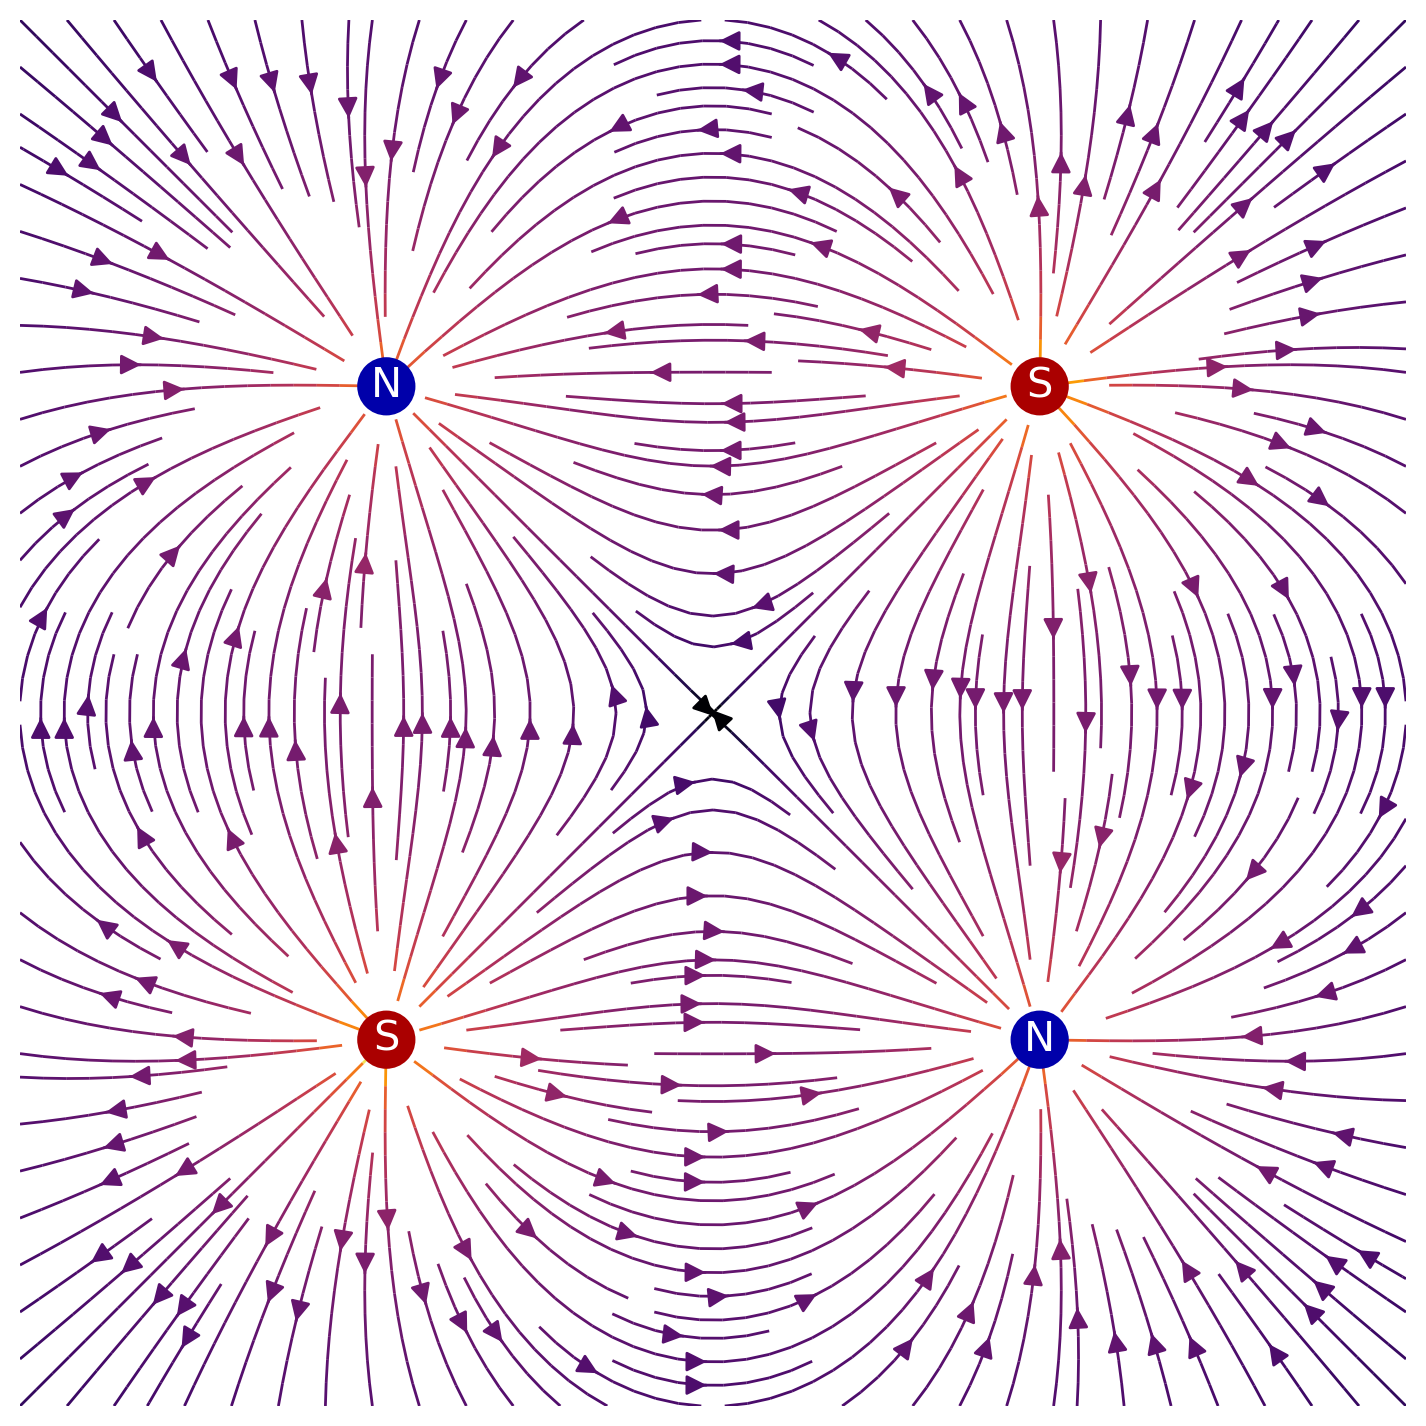

In [7]:
fig = plt.figure(figsize=(9, 9))
axis = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Ex, Ey))
axis.streamplot(x, y, Ex, Ey, color=color, linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle="-|>", arrowsize=1.5)
plot_multipole_charges(axis, charges)

axis.set_aspect("equal")
axis.set_axis_off()

# plt.savefig(f"plots/efield_multipole_order_{order}.pdf", dpi=500)
plt.show()

### Magnetic Field Map

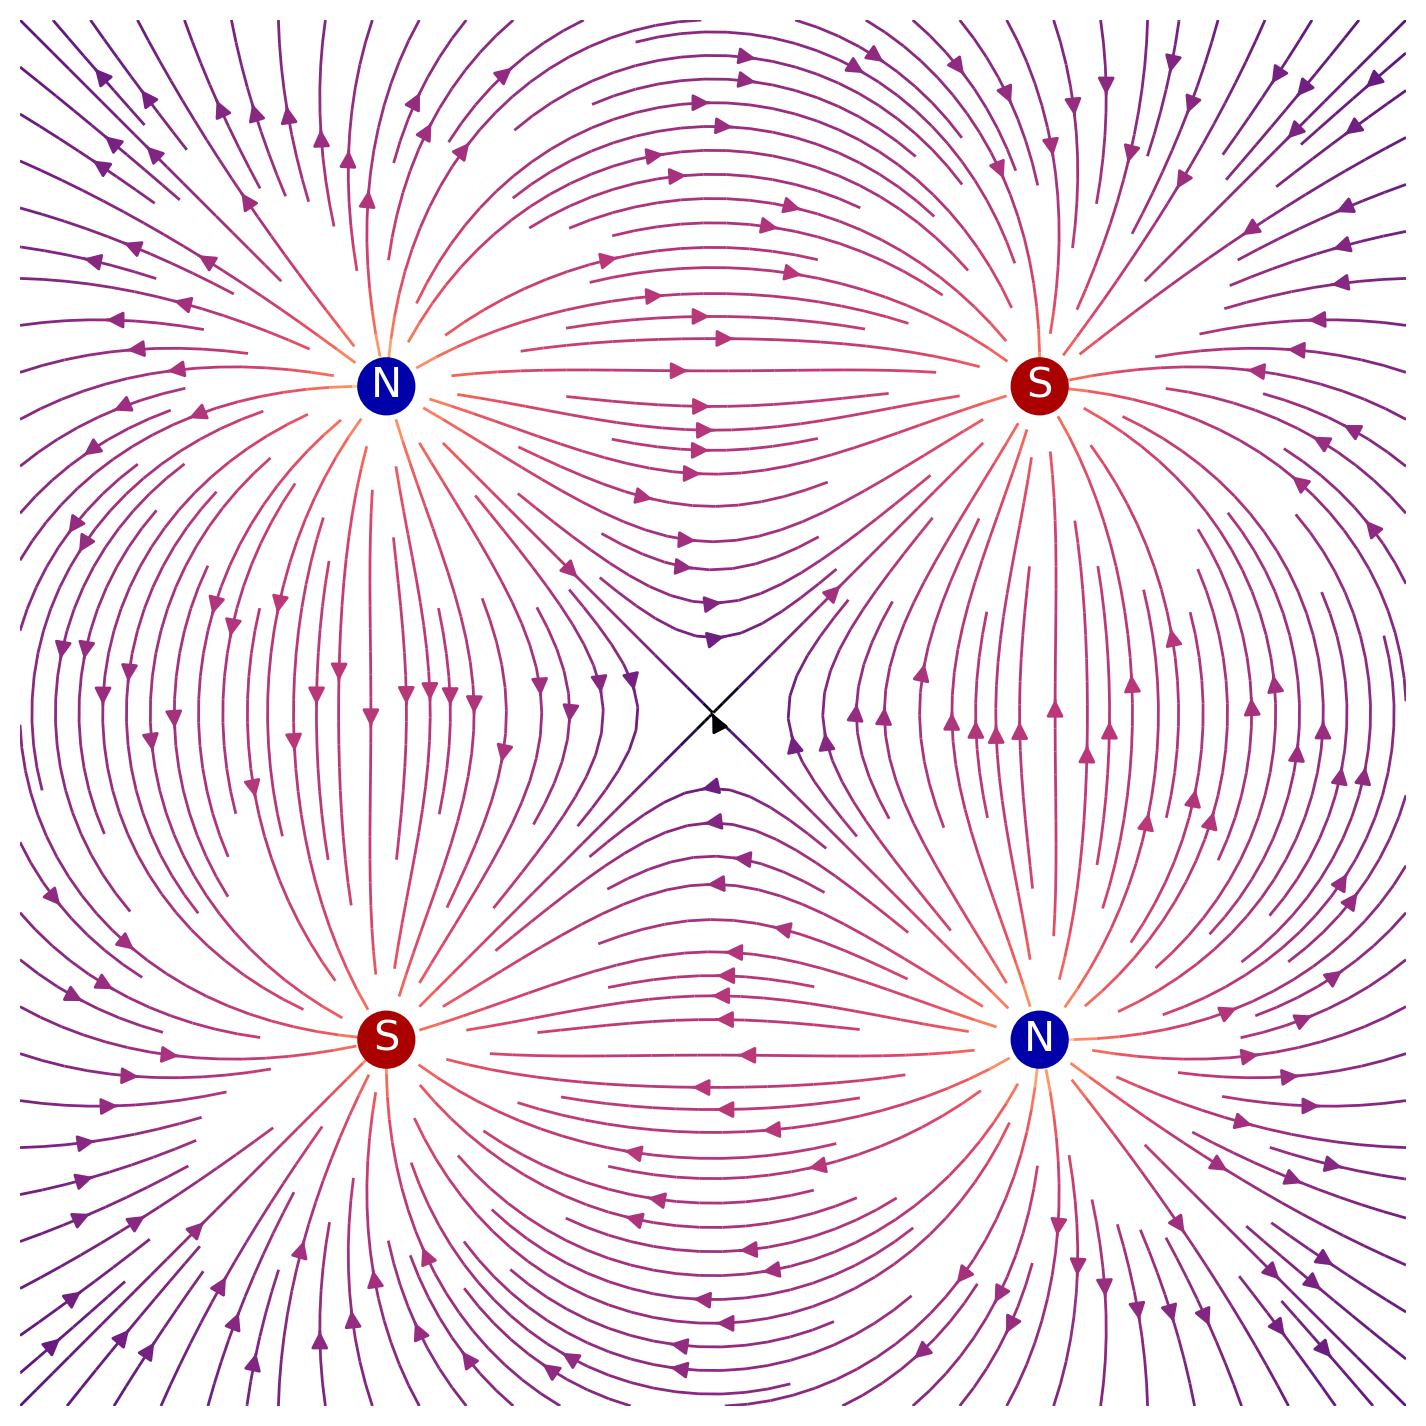

In [8]:
fig = plt.figure(figsize=(9, 9))
axis = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Bx, By))
axis.streamplot(x, y, Bx, By, color=color, linewidth=1, cmap=plt.cm.magma, density=2, arrowstyle="-|>", arrowsize=1.25)
plot_multipole_charges(axis, charges)

axis.set_aspect("equal")
axis.set_axis_off()

# plt.savefig(f"plots/bfield_normal_multipole_order_{order}.pdf", dpi=500)
plt.show()

## Skew Multipole

In [9]:
skew_charges = generate_multipole_charges(order, skew=True)
Ex_skew, Ey_skew = calculate_efield_map(n_x, n_y, skew_charges)
Bx_skew, By_skew = calculate_bfield_map(n_x, n_y, skew_charges)

### Electric Field Map

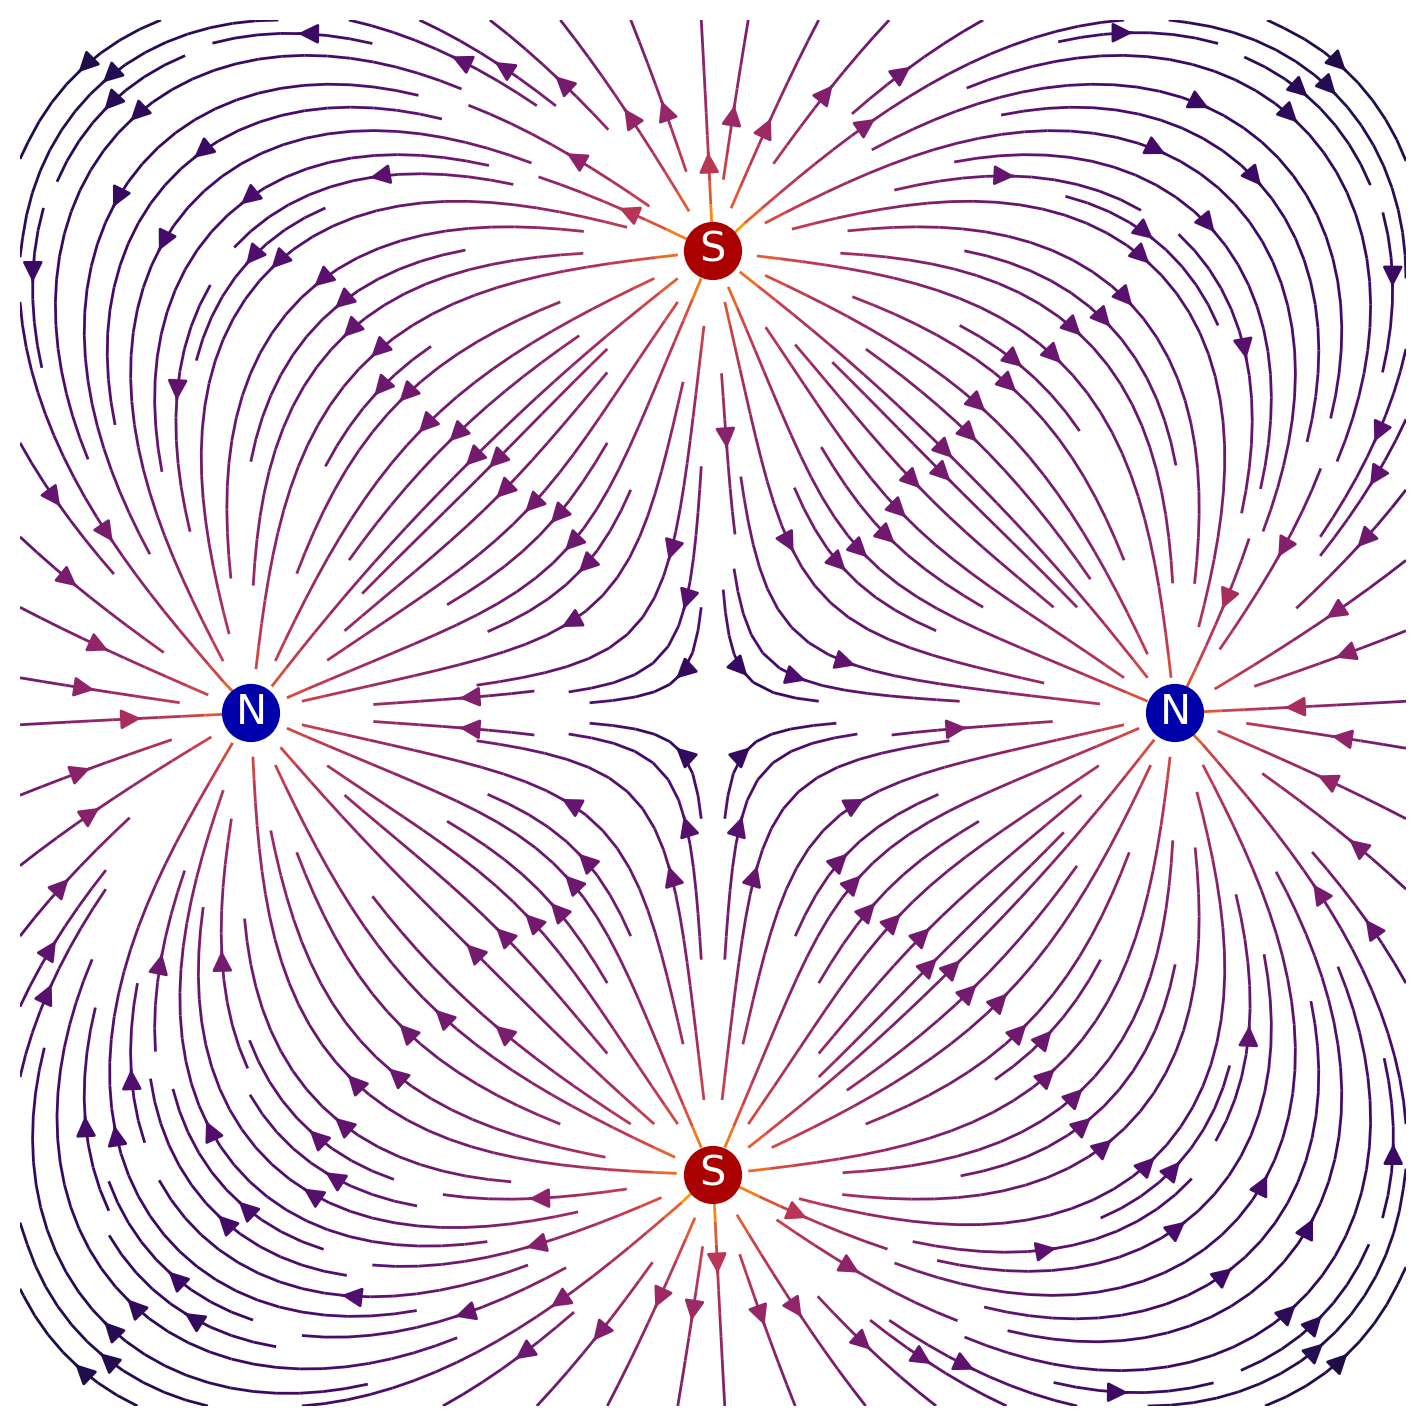

In [10]:
fig = plt.figure(figsize=(9, 9))
axis = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Ex_skew, Ey_skew))
axis.streamplot(x, y, Ex_skew, Ey_skew, color=color, linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle="-|>", arrowsize=1.5)
plot_multipole_charges(axis, skew_charges)

axis.set_aspect("equal")
axis.set_axis_off()

# plt.savefig(f"plots/efield_skew_multipole_order_{order}.pdf", dpi=500)
plt.show()

### Magnetic Field Map

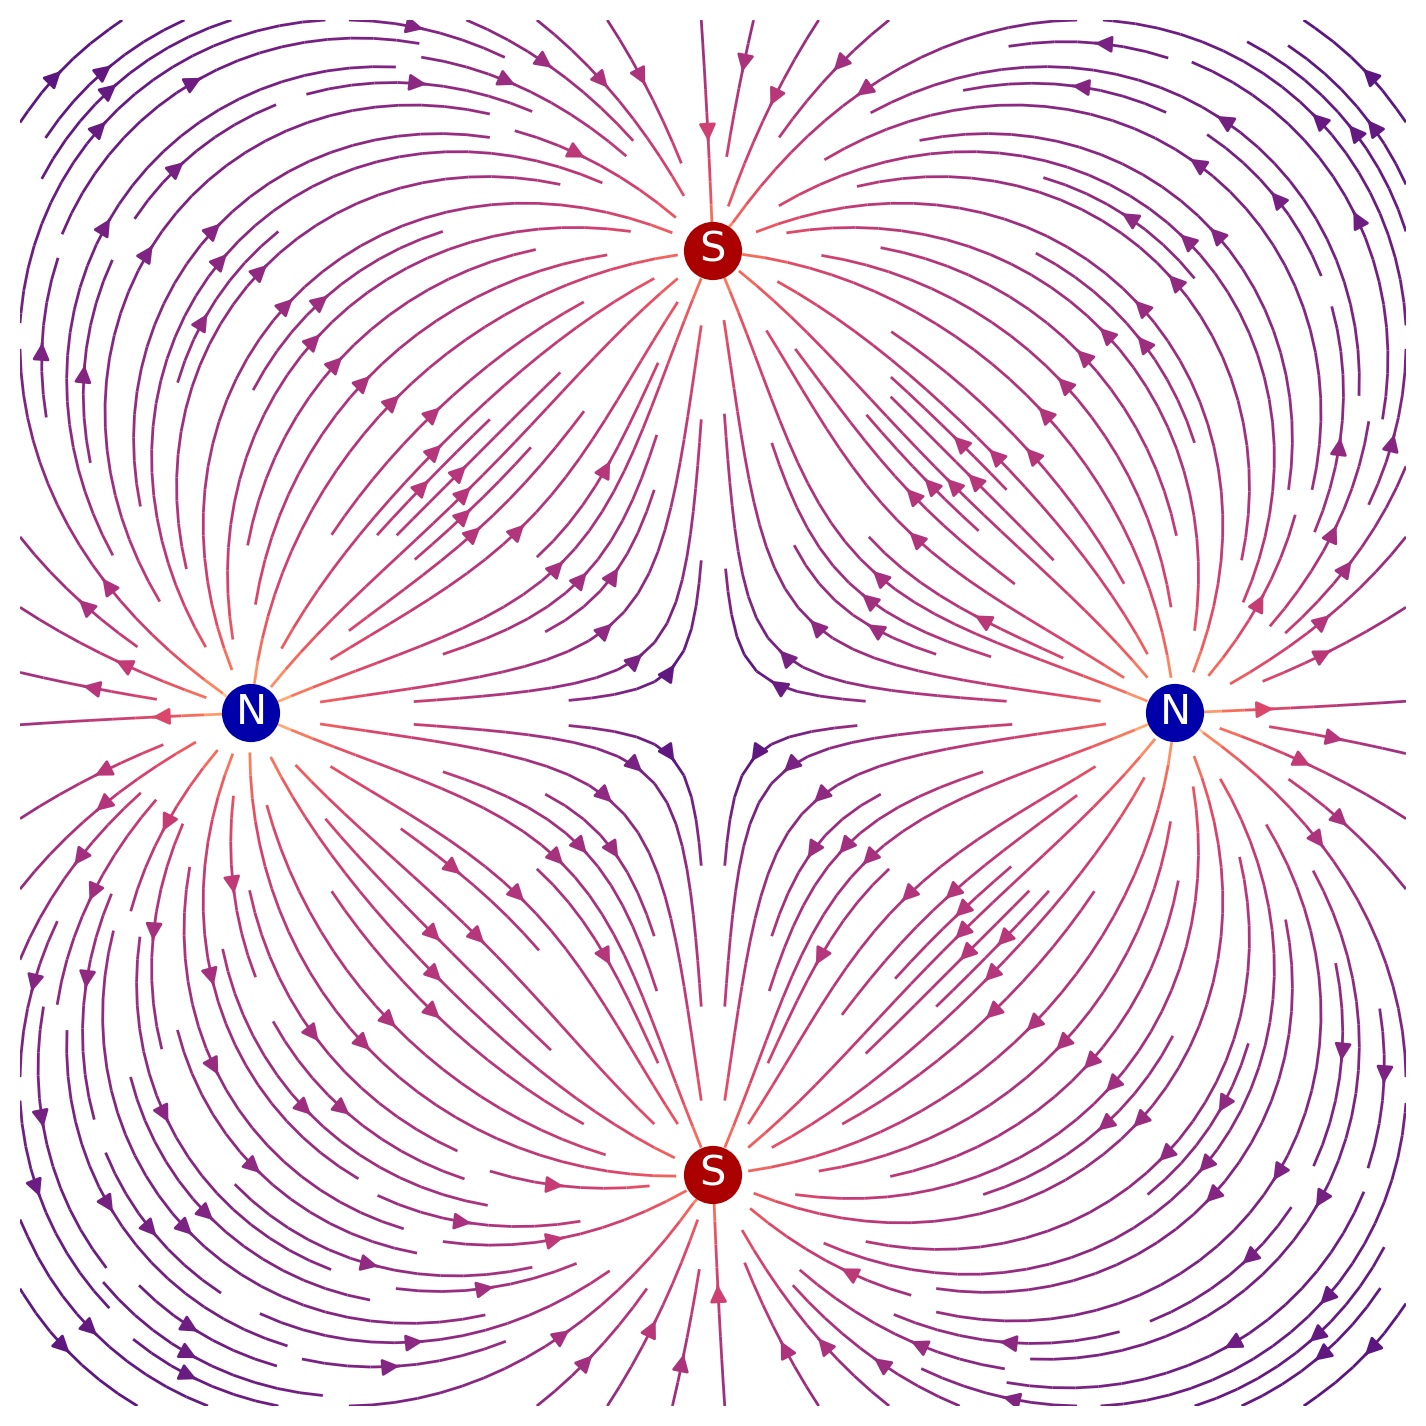

In [11]:
fig = plt.figure(figsize=(9, 9))
axis = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = 2 * np.log(np.hypot(Bx_skew, By_skew))
axis.streamplot(x, y, Bx_skew, By_skew, color=color, linewidth=1, cmap=plt.cm.magma, density=2, arrowstyle="-|>", arrowsize=1.25)
plot_multipole_charges(axis, skew_charges)

axis.set_aspect("equal")
axis.set_axis_off()

# plt.savefig(f"plots/bfield_skew_multipole_order_{order}.pdf", dpi=500)
plt.show()

## Both together

---